## Import libraries

In [1]:
from time import time
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
# from keras.applications.vgg16 import VGG16
from tensorflow.python.client import device_lib

# from keras.utils import plot_model
from keras.models import model_from_json
from keras.callbacks import TensorBoard

In [2]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8174185829367129836
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22682796032
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6738373941703904547
 physical_device_desc: "device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:b3:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
# Path to load the patch folder
train_data='DATA1/Train_aug'

In [4]:
# Function to define the phase (label) for each image
def label_encoder(img):
    label=img.split('.')[0]
    # print (label)
    if label=='aust':
        lb = 'Austenite'
    if label=='brain':
        lb = 'Bainite'
    if label=='ferr':
        lb = 'Ferrite'
    if label=='morten':
        lb = 'Martensite'
    if label=='parlite':
        lb = 'Pearlite'
    return lb

## DataLoader

In [5]:
def train_data_with_label():
    train_images=[]
    for i in tqdm(os.listdir(train_data)):
        path=os.path.join(train_data,i)
        # print(path)
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(128,128))
        train_images.append([np.array(img),label_encoder(i)])
    shuffle(train_images)
    return train_images

In [6]:
training_images = train_data_with_label()
tr_lbl_data = np.array([i[1] for i in training_images])

100%|██████████| 3051/3051 [00:02<00:00, 1017.04it/s]


### Ohe hot encoding
In this section the label in encoded like ohe hot encoder algorithm. Each phase is assigned to a different numpy array with binary number.

In [7]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
tr_encoded_lbl = ohe.fit_transform(tr_lbl_data.reshape(-1,1)).toarray()

In [8]:
tr_encoded_lbl

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]])

In [9]:
training_images[100]

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Ferrite']

In [10]:
tr_img_data = np.array([i[0] for i in training_images]).reshape(-1,128,128,1)#Flatten
tr_lbl_data = tr_encoded_lbl


## Train-test-split

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tr_img_data, tr_lbl_data, test_size=0.20,random_state=42)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2440, 128, 128, 1)
(2440, 5)
(611, 128, 128, 1)
(611, 5)


## Model Evaluation and analysis

In [36]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

In [37]:
from keras.models import load_model
model = load_model('best_resnet50_kfold.h5')

### Confusion matrix and classification report

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.BuPu):#Blues
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('COn.png',dpi=300)
    plt.show()

## multiclass or binary report
## If binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=32,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)

    # 2. Predict classes and stores in y_pred
    predict_x = model.predict(x, batch_size=batch_size)
    y_pred=np.argmax(predict_x,axis=1)

    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))

    print("")

    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))

    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)

In [39]:
inverse_test_array = np.array([[1,0,0,0,0,],[0,1,0,0,0,],[0,0,1,0,0,],
                               [0,0,0,1,0,],[0,0,0,0,1,]])

In [ ]:
# full_multiclass_report(model,
#                        tst_img_data,
#                        tst_lbl_data,
#                        ohe.inverse_transform(inverse_test_array))

20/20 [==============================] - 1s 24ms/step
Accuracy : 0.9918166939443536

Classification Report
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000       119
           1    1.00000   0.98333   0.99160       120
           2    1.00000   1.00000   1.00000       131
           3    1.00000   0.97521   0.98745       121
           4    0.96000   1.00000   0.97959       120

    accuracy                        0.99182       611
   macro avg    0.99200   0.99171   0.99173       611
weighted avg    0.99214   0.99182   0.99186       611

[[119   0   0   0   0]
 [  0 118   0   0   2]
 [  0   0 131   0   0]
 [  0   0   0 118   3]
 [  0   0   0   0 120]]


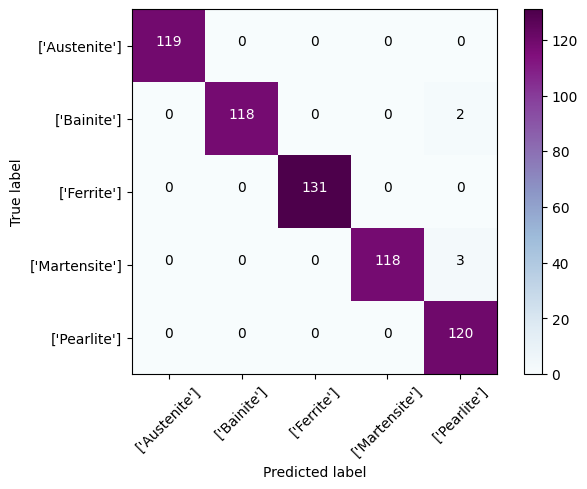

In [40]:
full_multiclass_report(model,
                       X_test,
                       y_test,
                       ohe.inverse_transform(inverse_test_array))

20/20 [==============================] - 1s 36ms/step
Number of incorrect predictions: 5


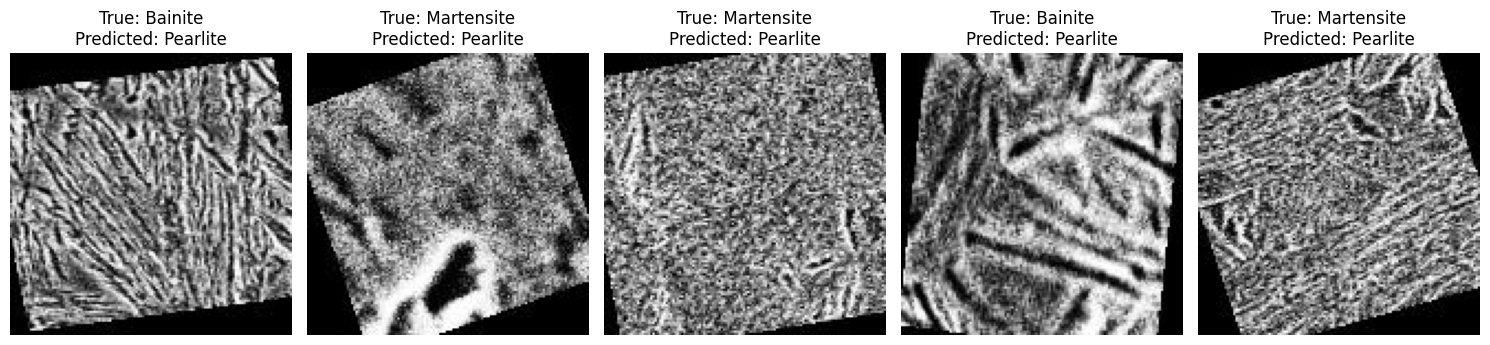

In [41]:
# Get the predictions from the best model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Get the class labels from the one-hot encoder
class_labels = ohe.categories_[0]

# Find the indices of incorrect predictions
incorrect_indices = np.where(y_pred_classes != y_true_classes)[0]

print(f"Number of incorrect predictions: {len(incorrect_indices)}")

# Display some of the incorrect predictions
num_display = 10  # Number of incorrect predictions to display
if len(incorrect_indices) > 0:
    plt.figure(figsize=(15, 10))
    for i, incorrect_index in enumerate(incorrect_indices[:num_display]):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X_test[incorrect_index].reshape(128, 128), cmap='gray')
        plt.title(f"True: {class_labels[y_true_classes[incorrect_index]]}\nPredicted: {class_labels[y_pred_classes[incorrect_index]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No incorrect predictions to display.")